In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython import display

In [2]:
from matplotlib import pyplot as plt
import torch
import bindsnet
import os
import numpy as np
import math

In [3]:
from time import time as t

from bindsnet.datasets import MNIST
from bindsnet.network import Network
from bindsnet.learning import WeightDependentPostPre
from bindsnet.encoding import bernoulli_loader
from bindsnet.network.monitors import NetworkMonitor
from bindsnet.network.nodes import Input, LIFNodes,IFNodes
from bindsnet.network.topology import Connection

### Set Parameters

In [4]:
init_weight_value = 0.8
weights_init_XY = torch.Tensor([[init_weight_value,  1-init_weight_value],
                                [ 1-init_weight_value, init_weight_value]
                               ])


# Learning
### STDP

learning_rate = 1

# Connections
wmin = 0.001
wmax = 1
weight_decay =  1.6e-5
post_spike_weight_decay = 0.0

# Neurons
reset = 0

#### Thresholds
refrac = 40
thresh = 5 #105

# Data encoding
intensity = 25
time = 1000

dt = 1

### Create Network

In [5]:
network = Network()
input_layer = Input(n=2, 
                    traces=True, 
                    thresh=thresh,
                    rest = reset,
                    reset=reset,
                    refrac=refrac
                   )

output_layer = LIFNodes(n=2, 
                       traces=True, 
                       thresh=thresh*torch.ones(2),
                       rest = reset,
                       reset=reset,
                       refrac=refrac,
                       astrocyte_receptive_field = 2
                       )

conn_XY = Connection(input_layer, 
                     output_layer, 
                     impulse_amplitude = 0.42,
                     impulse_amplitude_2 = 0.42,
                     impulse_length = 40,
                     impulse_shape_factor = 0.9,
                     invert = True,
                     update_rule=WeightDependentPostPre,
                     w=weights_init_XY, 
                     nu=[learning_rate, learning_rate], 
                     wmin=wmin, 
                     wmax=wmax,
                     weight_decay=weight_decay,
                     post_spike_weight_decay=post_spike_weight_decay
                     )

network.add_layer(input_layer, name='X')
network.add_layer(output_layer, name='Y')
network.add_connection(conn_XY, source='X', target='Y')

GlobalMonitor = NetworkMonitor(network, state_vars=('v', 's', 'w'))
network.add_monitor(GlobalMonitor, name='Network')

print('GlobalMonitor.state_vars:', GlobalMonitor.state_vars)

GlobalMonitor.state_vars: ('v', 's', 'w')


### Create Custom Dataset

In [6]:
len_dataset = 1
input_data = torch.zeros(len_dataset, 2)

for i in range(len_dataset):
    if i % 2 == 0:
        input_data[i] = torch.Tensor([1.0, 0.1]) #+ 0.3*torch.rand([1, 2])
    else:
        input_data[i] = torch.Tensor([0.1, 1.0]) #+ 0.3*torch.rand([1, 2])
        
    
input_data *= intensity

# Lazily encode data as Poisson spike trains.
data_loader = bernoulli_loader(data=(input_data/time)*dt, time=time)

# set visualize_sample = True to watch the example
visualize_sample = False

# display.update_display example
if visualize_sample:
    sample = next(data_loader)
    fig = plt.figure(figsize=(4,4))
    for i, sample in enumerate(data_loader):
        if i==0:
            plt.title('spike coding 0 0')
            plt.imshow(sample[0].view(2,1))
            plt.axis('off')
            display.display(fig, display_id = 'spike coding')

        for j, sample_t in enumerate(sample):
            plt.title('spike coding ' + str(i) + ' '+ str(j))
            plt.imshow(sample_t.view(2,1))
            plt.axis('off')
            display.update_display(fig, display_id = 'spike coding')
        print(i)
        
        break

    

### Цикл обучения

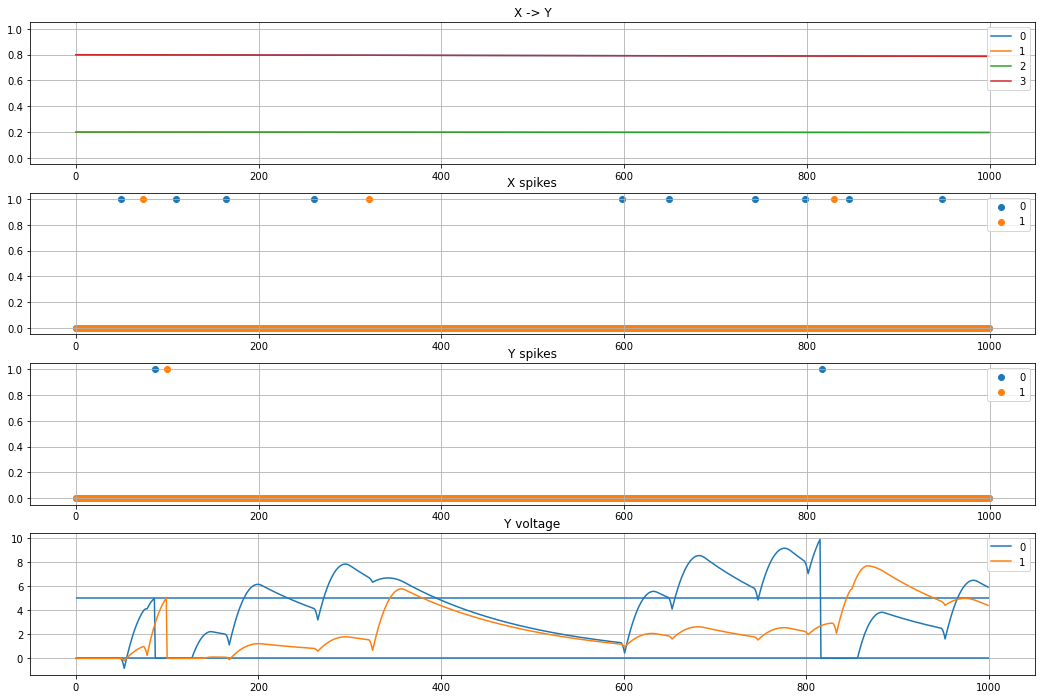

In [7]:
print('Begin training.\n');
start = t()
n_train = len_dataset # number of training examples
progress_interval = 1 # how often to plot progress

weights_total = torch.Tensor()
voltages_total = torch.Tensor()

for i in range(n_train):
    if i % progress_interval == 0:
        print('Progress: %d / %d (%.4f seconds)' % (i, n_train, t() - start));
        start = t()
    
    
    # Get next input sample.
    sample = next(data_loader)
    inpts = {'X': sample} # set sample to input X
    
    if i % 2 == 0:
        injects_v  = {'Y': torch.tensor([0.0, 0.0])} #Ток учителя
    else:
        injects_v  = {'Y': torch.tensor([0.0, 0.0])}

    # Run the network on the input.
    network.run(inpts=inpts, time=time, injects_v = injects_v)
    
    # get recordings
    recordings = network.monitors['Network'].get()
    
    weights = recordings[('X', 'Y')]['w'].view(-1, 4)
    voltages = recordings[('Y')]['v']
    
    if i==0:
        weights_total = weights
        voltages_total = voltages
        
    else:
        weights_total = torch.cat((weights_total, weights),0)
        voltages_total = torch.cat((voltages_total,voltages),0)
   
    
    # plot   
    # Weights
    fig_w = plt.figure(figsize=(18, 12))
    plt.subplot(4,1,1)
    plt.title('X -> Y')
    weights = recordings[('X', 'Y')]['w'].view(-1, 4)
    for j in range(weights.size(1)):
        plt.plot(np.arange(i*weights.size(0), (i+1)*weights.size(0)), weights[:,j].numpy(), label=str(j))
    plt.legend(loc='upper right')
    plt.ylim(-0.05, 1.05)
    plt.grid()
    
    # Spikes
    plt.subplot(4,1,2)
    plt.title('X spikes')
    spikes = recordings[('X')]['s']
    for j in range(spikes.size(2)):
        #plt.plot(np.arange(i*spikes.size(0), (i+1)*spikes.size(0)), spikes[:,:,j].numpy(), label=str(j))
        plt.scatter(np.arange(i*spikes.size(0), (i+1)*spikes.size(0)), spikes[:,:,j].numpy(), label=str(j))
    plt.legend(loc='upper right')
    plt.ylim(-0.05, 1.05)
    plt.grid()
    
    plt.subplot(4,1,3)
    plt.title('Y spikes')
    spikes = recordings[('Y')]['s']
    for j in range(spikes.size(2)):
        #plt.plot(np.arange(i*spikes.size(0), (i+1)*spikes.size(0)), spikes[:,:,j].numpy(), label=str(j))
        plt.scatter(np.arange(i*spikes.size(0), (i+1)*spikes.size(0)), spikes[:,:,j].numpy(), label=str(j))
    plt.legend(loc='upper right')
    plt.ylim(-0.05, 1.05)
    plt.grid()
    
    # Voltages
    plt.subplot(4,1,4)
    plt.title('Y voltage')
    voltages = recordings[('Y')]['v']
    for j in range(voltages.size(2)):
        plt.plot(np.arange(i*voltages.size(0), (i+1)*voltages.size(0)), voltages[:,:,j].numpy(), label=str(j))
    plt.legend(loc='upper right')
    plt.hlines([reset, thresh], i*voltages.size(0), (i+1)*voltages.size(0))
    plt.grid()
    
    display.clear_output(wait=True)
    display.display(fig_w, display_id = 'weights')
    
    network.reset_()
    
    plt.close(fig_w)
       

Text(0, 0.5, 'Voltage, В')

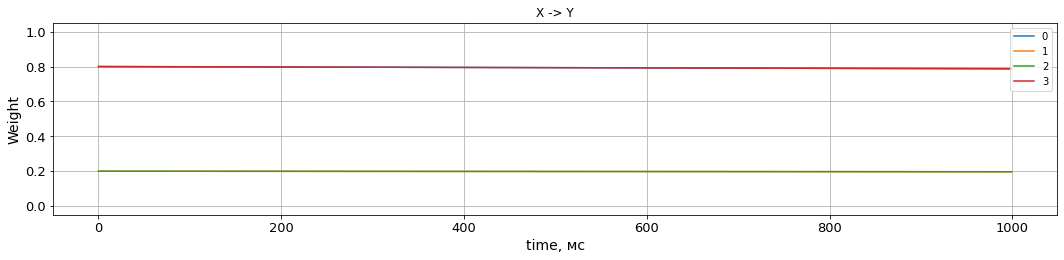

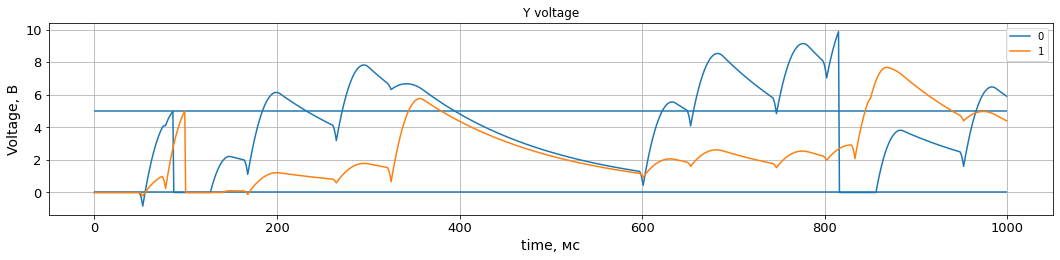

In [8]:
    fig_w = plt.figure(figsize=(18, 12))
    gr = fig_w.add_subplot(3,1,1)
    gr.set_title('X -> Y')
   # weights = recordings[('X', 'Y')]['w'].view(-1, 4)
    for j in range(weights_total.size(1)):
        gr.plot(range(weights_total.size(0)), weights_total[:,j].numpy(), label=str(j))
    gr.legend(loc='upper right')
    gr.set_ylim(-0.05, 1.05)
    gr.grid()
    gr.tick_params(axis='both', which='major', labelsize=13)

    gr.set_xlabel('time, мс',fontsize = 14)
    gr.set_ylabel('Weight',fontsize = 14)
    
    fig_w = plt.figure(figsize=(18, 12))
    gru = fig_w.add_subplot(3,1,3)
    gru.set_title('Y voltage')
    #voltages = recordings[('Y')]['v']
    for j in range(voltages.size(2)):
        gru.plot(range(voltages_total.size(0)), voltages_total[:,:,j].numpy(), label=str(j))
    gru.legend(loc='upper right')
    gru.hlines([reset, thresh], 0, voltages_total.size(0))
    gru.grid()
    gru.tick_params(axis='both', which='major', labelsize=13)

    gru.set_xlabel('time, мс',fontsize = 14)
    gru.set_ylabel('Voltage, В',fontsize = 14)